This notebook shows how to use LLM-Geo, you can uncomment a study case (preferred Case 1 and Case 3) to get the spatial analysis results without any human intervention. 

Please check the [webpage of LLM-Geo](https://github.com/gladcolor/LLM-Geo) for more detail!


#  Install package

In [1]:
# ! pip install pyvis
# ! pip install networkx
# ! pip install openai

# Import package

In [2]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
from openai import OpenAI
from IPython.display import display, HTML, Code
from IPython.display import clear_output

# Define Solution class
Please run the following cell to define the functions

In [3]:
%load_ext autoreload
%autoreload 2

import LLM_Geo_Constants as constants
import helper

from LLM_Geo_kernel import Solution



# Demonstration Cases

## Input task and data desciption

In [4]:
isReview = True

In [5]:

# Case 1: population living near hazardous wastes

task_name ='Resident_at_risk_counting'
TASK = r"""1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
2) Generate a population choropleth map for all tract polygons in NC, rendering the color by tract population; and then highlight the borders of tracts that have hazardous waste facilities. Please draw all polygons, not only the highlighted ones. The map size is 15*10 inches.
"""

DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip.",
                  "NC tract boundary shapefile: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip. The tract ID column is 'GEOID', data types is integer.",
                  "NC tract population CSV file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID', data types is integer."
                 ]
 


# # Case 3: COVID-19 death rate in US
# task_name ='COVID_death_rate'
# TASK = r'''1) Draw a choropleth map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
# 2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red. Set figure size to 15*10 inches.  
# '''


# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'; map projection is EPSG:4269",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
#                  ]



# # Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'
# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map of zipcode area polygons (unit: km), also show the hospital.
# '''

# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
# ]


## Case 5: Census API
# task_name ='Census_API'
# TASK = r''' Show the spatial distribution of the county level median income in the contigous US. Set figure size to (25,15)
# '''

# DATA_LOCATIONS = [
#       "You can use the Census API.",
# ]

# DATA_LOCATIONS = [
# '''Census API key: ae7be70727932dd6aed257692de3f344365d0678'''              
# ]


# # Case 2: France_mobility_changes_2020  (NOTE: invalidated due to API shutdown)
# task_name ='France_mobility_changes_2020'
# TASK = r'''
# 1) Show the 2020 human mobility monthly change rates of each administrative regions in a France choropleth map. Each month is a sub-map in a map matrix，12 months in total. All monthly maps need to use the same colorbar range (color scheme: coolwarm). The base of the change rate is January 2020. 
# 2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line (the region name is the legend), the x-axis is 2020 months.
# '''

# DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
#                   "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
#                   "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
#                   "REST API url with parameters for daily human mobility data access:" + \
#                   "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
#                   "The response is in CSV format. There are three columns in the response: " + \
#                   "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country;" + \
#                   "codes for France administrative regions start with 'FRA'. Use the total intra_movement of the month as the montly mobility.",
#                  ]


save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-4"
model = r'gpt-4o'
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and programmer good at Python. You have worked on Geographic information science more than 20 years, and know every detail and pitfall when processing spatial data and coding. You know well how to set up workflows for spatial analysis tasks. You have significant experence on graph theory, application, and implementation. You are also experienced on generating map using Matplotlib and GeoPandas.
 

Your task: Generate a graph (data structure) only, whose nodes are (1) a series of consecutive steps and (2) data to solve this question:  
 1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
2) Generate a population choropleth map for all tract polygons in NC, rendering the color by tract population; and then highlight the borders of tracts that have hazardous waste facilities. Please d

## Get graph code from GPT API

In [6]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_graph, language='python'))

import networkx as nx

G = nx.DiGraph()

# Data nodes
G.add_node("haz_waste_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip", description="NC hazardous waste facility ESRI shape file URL")
G.add_node("tract_boundary_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip", description="NC tract boundary shapefile URL")
G.add_node("tract_population_csv_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv", description="NC tract population CSV file URL")

# Operation nodes
G.add_node("load_haz_waste_shp", node_type="operation", description="Load hazardous waste facility shapefile")
G.add_node("load_tract_boundary_shp", node_type="operation", description="Load NC tract boundary shapefile")
G.add_node("load_tract_population_csv", node_type="operation", description="Load NC tract population CSV")

G.add_node("identify_tracts_with_haz_waste", node_type="operation", description="Find out Census tracts that contain hazardous waste facilities")
G.add_node("join_population_to_tracts", node_type="operation", description="Join population data to tract polygons")
G.add_node("compute_population_at_risk", node_type="operation", description="Compute and print out the population living in tracts with hazardous waste facilities")
G.add_node("generate_choropleth_map", node_type="operation", description="Generate population choropleth map and highlight tracts with hazardous waste facilities")

# Output data nodes
G.add_node("haz_waste_gdf", node_type="data", description="Hazardous waste facility GeoDataFrame")
G.add_node("tract_boundary_gdf", node_type="data", description="NC tract boundary GeoDataFrame")
G.add_node("tract_population_df", node_type="data", description="NC tract population DataFrame")
G.add_node("tracts_with_haz_waste_gdf", node_type="data", description="GeoDataFrame of tracts with hazardous waste facilities")
G.add_node("tract_population_joined_gdf", node_type="data", description="GeoDataFrame of tracts with population data")
G.add_node("population_at_risk", node_type="data", description="Total population living in tracts with hazardous waste facilities")
G.add_node("choropleth_map", node_type="data", description="Population choropleth map with highlighted tracts with hazardous waste facilities")

# Edges
G.add_edge("haz_waste_shp_url", "load_haz_waste_shp")
G.add_edge("tract_boundary_shp_url", "load_tract_boundary_shp")
G.add_edge("tract_population_csv_url", "load_tract_population_csv")

G.add_edge("load_haz_waste_shp", "haz_waste_gdf")
G.add_edge("load_tract_boundary_shp", "tract_boundary_gdf")
G.add_edge("load_tract_population_csv", "tract_population_df")

G.add_edge("haz_waste_gdf", "identify_tracts_with_haz_waste")
G.add_edge("tract_boundary_gdf", "identify_tracts_with_haz_waste")
G.add_edge("identify_tracts_with_haz_waste", "tracts_with_haz_waste_gdf")

G.add_edge("tract_boundary_gdf", "join_population_to_tracts")
G.add_edge("tract_population_df", "join_population_to_tracts")
G.add_edge("join_population_to_tracts", "tract_population_joined_gdf")

G.add_edge("tracts_with_haz_waste_gdf", "compute_population_at_risk")
G.add_edge("tract_population_joined_gdf", "compute_population_at_risk")
G.add_edge("compute_population_at_risk", "population_at_risk")

G.add_edge("tract_population_joined_gdf", "generate_choropleth_map")
G.add_edge("tracts_with_haz_waste_gdf", "generate_choropleth_map")
G.add_edge("generate_choropleth_map", "choropleth_map")

# Note: The graph is ready but the actual implementation of operations
# would require Python coding which is not included as per instructions.

## Execute code to generate the solution graph

In [7]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

F:\Research\LLM-Geo\Resident_at_risk_counting.html


## Generate prompts and code for operations (functions)

In [8]:
operations = solution.get_LLM_responses_for_operations(review=isReview)
solution.save_solution()

all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])

clear_output(wait=True)
display(Code(all_operation_code_str, language='python'))

import geopandas as gpd

def load_haz_waste_shp(haz_waste_shp_url="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip"):
    """
    Description: Load hazardous waste facility shapefile
    haz_waste_shp_url: URL to the zipped ESRI shapefile for hazardous waste facilities
    Returns: GeoDataFrame of the hazardous waste facilities
    """
    haz_waste_gdf = gpd.read_file(haz_waste_shp_url)
    return haz_waste_gdf
import geopandas as gpd

def load_tract_boundary_shp(tract_boundary_shp_url="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip"):
    """
    Description: Load NC tract boundary shapefile from a provided URL and return a GeoDataFrame
    tract_boundary_shp_url: URL to the zipped shapefile for NC tract boundaries
    """
    tract_boundary_gdf = gpd.read_file(tract_boundary_shp_url)
    
    # Ensure GEOID is treated as string to maintain leading zeros and for consistency in joins
    if 'GEOID' in tract_boundary_gdf.columns:
        tract_boundary_gdf['GEOID'] = tract_boundary_gdf['GEOID'].astype(str)
    
    return tract_boundary_gdf
import pandas as pd

def load_tract_population_csv(tract_population_csv_url="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv"):
    # Description: Load NC tract population CSV
    tract_population_df = pd.read_csv(tract_population_csv_url, dtype={'GEOID': 'int', 'TotalPopulation': 'int'}).dropna(subset=['GEOID', 'TotalPopulation'])
    return tract_population_df
import pandas as pd
import geopandas as gpd

def join_population_to_tract(tract_boundary_gdf, tract_population_df):
    """
    Description: Join population data to tract boundaries
    """
    # Ensure both GeoDataFrame and DataFrame have 'GEOID' column in the same format.
    tract_population_df['GEOID'] = tract_population_df['GEOID'].astype(str)
    tract_boundary_gdf['GEOID'] = tract_boundary_gdf['GEOID'].astype(str)

    # Merge the GeoDataFrame and DataFrame based on the 'GEOID' column.
    tract_population_gdf = tract_boundary_gdf.merge(tract_population_df, on='GEOID', how='left')

    return tract_population_gdf
import geopandas as gpd

def identify_tracts_with_haz_waste(haz_waste_gdf, tract_boundary_gdf):
    """
    Description: Identify tracts containing hazardous waste facilities
    """
    # Ensure both GeoDataFrames are using the same projection
    if haz_waste_gdf.crs != tract_boundary_gdf.crs:
        haz_waste_gdf = haz_waste_gdf.to_crs(tract_boundary_gdf.crs)

    # Spatial join: identify tracts that contain hazardous waste facilities
    tracts_with_haz_waste_gdf = gpd.sjoin(tract_boundary_gdf, haz_waste_gdf, how='inner', predicate='intersects')
    
    # Because spatial join might create duplicate entries for tracts containing more than one haz waste facility, we drop duplicates to ensure each tract is represented once
    tracts_with_haz_waste_gdf = tracts_with_haz_waste_gdf.drop_duplicates(subset=['GEOID'])

    return tracts_with_haz_waste_gdf
def calculate_population_at_risk(tracts_with_haz_waste_gdf, tract_population_joined_gdf):
    """
    Description: Calculate total population in tracts with hazardous waste facilities
    """
    # Ensure both GeoDataFrames have 'GEOID' column in the same format.
    tracts_with_haz_waste_gdf['GEOID'] = tracts_with_haz_waste_gdf['GEOID'].astype(str)
    tract_population_joined_gdf['GEOID'] = tract_population_joined_gdf['GEOID'].astype(str)

    # Filter the tract_population_joined_gdf for only those tracts that have hazardous waste facilities.
    at_risk_population_gdf = tract_population_joined_gdf[tract_population_joined_gdf['GEOID'].isin(tracts_with_haz_waste_gdf['GEOID'])]

    # Calculate the total population at risk
    population_at_risk = at_risk_population_gdf['TotalPopulation'].sum()

    return population_at_risk
import matplotlib.pyplot as plt
import geopandas as gpd

def generate_choropleth_map(tract_population_gdf, tracts_with_haz_waste

## Generate prompts and code for assembly program

In [9]:
assembly_LLM_response = solution.get_LLM_assembly_response(review=isReview)
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_assembly, language='python'))

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def assembely_solution():
    # Load Data
    haz_waste_gdf = load_haz_waste_shp()
    tract_boundary_gdf = load_tract_boundary_shp()
    tract_population_df = load_tract_population_csv()

    # Join population data to tract boundaries
    tract_population_joined_gdf = join_population_to_tract(tract_boundary_gdf, tract_population_df)

    # Identify tracts with hazardous waste facilities
    tracts_with_haz_waste_gdf = identify_tracts_with_haz_waste(haz_waste_gdf, tract_boundary_gdf)

    # Calculate total population living in tracts with hazardous waste facilities
    population_at_risk = calculate_population_at_risk(tracts_with_haz_waste_gdf, tract_population_joined_gdf)
    print(f"Total Population in tracts with hazardous waste facilities: {population_at_risk}")

    # Generate Population choropleth map highlighting tracts with hazardous waste
    generate_choropleth_map(tract_population_joined_gdf, tracts_with_haz_waste_gdf)
    plt.savefig("NC_population_choropleth_with_haz_waste_tracts.png", dpi=300)

# Function definitions required for assembely_solution()
def load_haz_waste_shp(haz_waste_shp_url="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip"):
    haz_waste_gdf = gpd.read_file(haz_waste_shp_url)
    return haz_waste_gdf

def load_tract_boundary_shp(tract_boundary_shp_url="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip"):
    tract_boundary_gdf = gpd.read_file(tract_boundary_shp_url)
    if 'GEOID' in tract_boundary_gdf.columns:
        tract_boundary_gdf['GEOID'] = tract_boundary_gdf['GEOID'].astype(str)
    return tract_boundary_gdf

def load_tract_population_csv(tract_population_csv_url="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv"):
    tract_population_df = pd.read_csv(tract_population_csv_url, dtype={'GEOID': 'str', 'TotalPopulation': 'int'}).dropna(subset=['GEOID', 'TotalPopulation'])
    return tract_population_df

def join_population_to_tract(tract_boundary_gdf, tract_population_df):
    tract_population_df['GEOID'] = tract_population_df['GEOID'].astype(str)
    tract_boundary_gdf['GEOID'] = tract_boundary_gdf['GEOID'].astype(str)
    tract_population_gdf = tract_boundary_gdf.merge(tract_population_df, on='GEOID', how='left')
    return tract_population_gdf

def identify_tracts_with_haz_waste(haz_waste_gdf, tract_boundary_gdf):
    if haz_waste_gdf.crs != tract_boundary_gdf.crs:
        haz_waste_gdf = haz_waste_gdf.to_crs(tract_boundary_gdf.crs)
    tracts_with_haz_waste_gdf = gpd.sjoin(tract_boundary_gdf, haz_waste_gdf, how='inner', predicate='intersects')
    tracts_with_haz_waste_gdf = tracts_with_haz_waste_gdf.drop_duplicates(subset=['GEOID'])
    return tracts_with_haz_waste_gdf

def calculate_population_at_risk(tracts_with_haz_waste_gdf, tract_population_joined_gdf):
    tracts_with_haz_waste_gdf['GEOID'] = tracts_with_haz_waste_gdf['GEOID'].astype(str)
    tract_population_joined_gdf['GEOID'] = tract_population_joined_gdf['GEOID'].astype(str)
    at_risk_population_gdf = tract_population_joined_gdf[tract_population_joined_gdf['GEOID'].isin(tracts_with_haz_waste_gdf['GEOID'])]
    population_at_risk = at_risk_population_gdf['TotalPopulation'].sum()
    return population_at_risk

def generate_choropleth_map(tract_population_gdf, tracts_with_haz_waste_gdf):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    tract_population_gdf.plot(column='TotalPopulation', ax=ax, legend=True, legend_kwds={'label': "Population by Tract", 'orientation': "horizontal"})
    tracts_with_highlight = tract_population_gdf[tract_population_gdf['GEOID'].isin(tracts_with_haz_waste_gdf['GEOID'])]
    tracts_with_highlight.boundary.plot(ax=ax, color='red', linewidth=2)
    ax.set_title('Population Choropleth Map with Highlight on Tracts Containing Hazardous Waste Facilities', fontsize=14)
    ax.set_xlabel('Longitude', fontsize=

## Execute assembly code



-------------- Running code (trial # 1/10) --------------


Total Population in tracts with hazardous waste facilities: 5683893


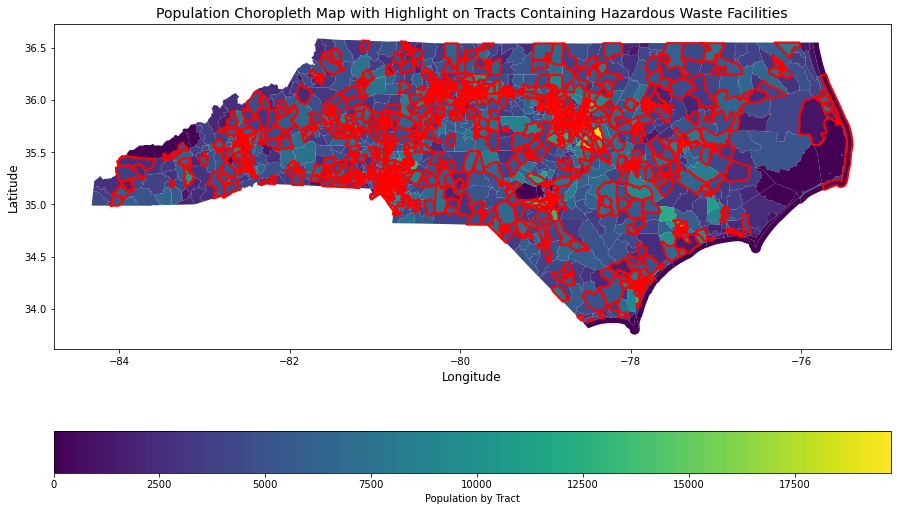



--------------- Done ---------------




<Figure size 432x288 with 0 Axes>

In [10]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly

# display(Code(all_code, language='python'))

all_code = solution.execute_complete_program(code=all_code, try_cnt=10)